Продакт-менеджер Василий попросил вас проанализировать завершенные уроки и ответить на следующие вопросы:

**Задачи**

1. Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене) (7 баллов).

2. Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью*. (5 баллов)

3. По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом). (5 баллов) 

4. Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3). (8 баллов)

5. Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.  (10 баллов) 

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. В адаптированной кластеризации можешь выбрать следующие метрики: R - среднее время сдачи одного экзамена, F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Описание подхода можно найти тут. (35 баллов)

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться курсом. Обосновать свой выбор ты можешь с помощью фактов сдачи экзаменов, распределения студентов и уникальный идентефикатор курса.

*завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен

In [114]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import urllib
from urllib.parse import urlencode
import json

In [116]:
# публичные ссылки на Яндекс.Диск
assessment = 'https://disk.yandex.ru/d/iSVP1sZ7AdW7TQ'
course = 'https://disk.yandex.ru/d/jmJxR8yhwCXlaw'
studentassessment = 'https://disk.yandex.ru/d/DYd4M5b_8RETsA'
studentregistration = 'https://disk.yandex.ru/d/lqHnH8NOZ458iw'

In [117]:
# создаем функцию для скачивания таблицы по ссылке
def get_yandex_download_url(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url

In [211]:
# загружаем таблицы
assessments = pd.read_csv(get_yandex_download_url(assessment))
courses =  pd.read_csv(get_yandex_download_url(course))
student_assessment =  pd.read_csv(get_yandex_download_url(studentassessment))
registration = pd.read_csv(get_yandex_download_url(studentregistration))

## Сколько студентов успешно сдали только один курс?

**Студенты, сдававшие экзамены для курса**

In [119]:
# информация по длительности семестра
courses.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


Какие предметы имеют экзамены?

In [120]:
exams = assessments.query('assessment_type == "Exam"')
exams

,code_module,code_presentation,id_assessment,assessment_type,date,weight
5,AAA,2013J,1757,Exam,NaN,100.0
11,AAA,2014J,1763,Exam,NaN,100.0
23,BBB,2013B,14990,Exam,NaN,100.0
35,BBB,2013J,15002,Exam,NaN,100.0
47,BBB,2014B,15014,Exam,NaN,100.0
53,BBB,2014J,15025,Exam,NaN,100.0
62,CCC,2014B,24290,Exam,NaN,100.0
63,CCC,2014B,40087,Exam,NaN,100.0
72,CCC,2014J,24299,Exam,NaN,100.0
73,CCC,2014J,40088,Exam,NaN,100.0


Объеденим таблицу с результатами студентов с данными о экзаменах

In [121]:
who_passed = student_assessment.merge(exams, how = 'inner', on = 'id_assessment')
who_passed.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
0,24290,558914,230,0,32.0,CCC,2014B,Exam,NaN,100.0
1,24290,559706,234,0,78.0,CCC,2014B,Exam,NaN,100.0
2,24290,559770,230,0,54.0,CCC,2014B,Exam,NaN,100.0
3,24290,560114,230,0,64.0,CCC,2014B,Exam,NaN,100.0
4,24290,560311,234,0,100.0,CCC,2014B,Exam,NaN,100.0


Теперь у нас есть таблица с результатами студентов, которые сдавали экзамены.

Экзамены по каким предметам сдавали студенты за все время?

In [122]:
who_passed.groupby(['code_module','code_presentation'], as_index = False)\
          .agg({'id_student':'count'})

,code_module,code_presentation,id_student
0,CCC,2014B,747
1,CCC,2014J,1168
2,DDD,2013B,602
3,DDD,2013J,968
4,DDD,2014B,524
5,DDD,2014J,950


Только для предметов 'CCC' и 'DDD' есть экзамены. 

Предположим, что курс включает в себя один предмет с двумя экзаменами в разные семестры в течение одного года. Тогда обозначения 2014B и 2013J - это год и семестр. Проверим теорию, что курс включает в себя один предмет с двумя экзаменами в двух семестрах, принадлежащих одному году.

Отбираем студентов, успешно сдавших эказмен по определенному предмету в определенный семестр

In [123]:
B2014c = who_passed.query('score >= 40 and code_presentation == "2014B" and code_module == "CCC"')

In [124]:
B2014c = list(B2014c['id_student'])
B2014c

[559706,
 559770,
 560114,
 560311,
 560494,
 561363,
 561559,
 561774,
 562450,
 562825,
 563046,
 563819,
 565399,
 566310,
 566428,
 566670,
 566715,
 568084,
 569080,
 569108,
 569609,
 570410,
 570872,
 570967,
 571129,
 571571,
 571776,
 572036,
 572303,
 572438,
 572570,
 572854,
 572891,
 573377,
 573440,
 573558,
 574221,
 574817,
 575733,
 575745,
 575824,
 575967,
 576383,
 576413,
 576475,
 576780,
 577035,
 577236,
 577414,
 577502,
 578189,
 578655,
 578850,
 578958,
 579343,
 579550,
 580525,
 580779,
 581611,
 581614,
 582879,
 582950,
 583032,
 583052,
 583192,
 583906,
 584191,
 584446,
 584940,
 585057,
 585093,
 585383,
 585393,
 585397,
 585455,
 585695,
 585709,
 587783,
 587906,
 587911,
 588274,
 588430,
 588473,
 588524,
 588676,
 588707,
 588956,
 589390,
 589525,
 591375,
 591388,
 591958,
 592151,
 592775,
 592776,
 592961,
 592976,
 593103,
 593305,
 593823,
 593972,
 593995,
 594044,
 594157,
 594371,
 595164,
 595182,
 595189,
 595659,
 595797,
 595847,
 

In [125]:
J2014c  = who_passed.query('score >= 40 and code_presentation == "2014J" and code_module == "CCC"')

In [126]:
J2014c =  list(J2014c['id_student'])

Сравниваем на совпадения два списка с отобранными id студентов

In [127]:
result_c = list(set(B2014c) & set(J2014c))

In [128]:
result_c

[]

Совпадений нет

Отбираем студентов по другому предмету

In [129]:
B2014d = who_passed.query('score >= 40 and code_presentation == "2014B" and code_module == "DDD"')

In [130]:
B2014d = list(B2014d['id_student'])
B2014d

[24213,
 50476,
 51030,
 64450,
 67781,
 84576,
 84605,
 88490,
 88910,
 89904,
 90537,
 117281,
 118479,
 127580,
 138416,
 138704,
 145114,
 145640,
 165178,
 187663,
 192186,
 201151,
 228272,
 232827,
 239459,
 240486,
 240755,
 242633,
 260565,
 264723,
 266922,
 271974,
 277166,
 285412,
 312761,
 317801,
 321810,
 325044,
 333308,
 339513,
 355309,
 355935,
 356166,
 356297,
 363122,
 367127,
 367646,
 370865,
 374645,
 375856,
 378728,
 382051,
 385927,
 386671,
 387963,
 390026,
 391924,
 395288,
 402314,
 407303,
 411060,
 412663,
 416008,
 418453,
 418781,
 424880,
 426297,
 430678,
 431406,
 434841,
 440103,
 440331,
 441213,
 442873,
 443861,
 445857,
 447162,
 464685,
 465413,
 467230,
 469614,
 470733,
 472257,
 472284,
 472651,
 479649,
 480956,
 481863,
 484213,
 484762,
 486022,
 489507,
 491036,
 492095,
 492537,
 498363,
 501487,
 502004,
 502057,
 502207,
 505815,
 513687,
 513957,
 515331,
 517864,
 520962,
 522840,
 523857,
 523978,
 524137,
 525412,
 525635,
 52

In [131]:
J2014d  = who_passed.query('score >= 40 and code_presentation == "2014J" and code_module == "DDD"')

In [132]:
J2014d =  list(J2014d['id_student'])

In [133]:
result_d = list(set(B2014d) & set(J2014d))

In [134]:
result_d

[]

Совпадений нет

На примере предметов с code_module = 'CCC' и 'DDD' мы видим, что нет студентов, успешно сдававших один предмет в два семестра, а значит теория неверна. Проверим теорию, что курс включает в себя два разных экзаменационных предмета.  

In [135]:
result_cd = list(set(B2014c) & set(B2014d))

In [136]:
result_cd

[630178, 1671811, 629710, 623347, 2609908, 617781, 630613, 467230, 628575]

In [137]:
result_dc = list(set(J2014d) & set(J2014c))

In [138]:
result_dc

[552965,
 678790,
 640773,
 653452,
 685964,
 685458,
 648854,
 642838,
 689050,
 447644,
 411549,
 577566,
 645792,
 689190,
 647464,
 654504,
 680492,
 690733,
 1078701,
 676538,
 686268,
 690365,
 646589,
 693058,
 686018,
 422343,
 80329,
 636364,
 574928,
 555989,
 2285527,
 689759,
 275297,
 676964,
 685412,
 695270,
 651495,
 1991399,
 2622441,
 608746,
 687981,
 651759,
 523762,
 651508,
 686584,
 692603,
 691069]

In [139]:
result_bdc = list(set(B2014d) & set(J2014c))
result_bdc

[1332356,
 614804,
 624789,
 630935,
 628376,
 618649,
 634648,
 629405,
 624927,
 615075,
 613667,
 602533,
 616870,
 631851,
 1552044,
 633008,
 618683,
 609852,
 629696,
 620231,
 634824,
 472651,
 1031884,
 622541,
 554065,
 616658,
 593657,
 598102,
 569944,
 614265,
 631771,
 546654,
 355935,
 145640,
 633960,
 2172136,
 2394090,
 624493,
 625263,
 1592048,
 1874160,
 627184,
 634351,
 621300,
 622192,
 626417,
 412663,
 628216,
 561913,
 613370,
 387963,
 574590,
 578815]

В результате есть пересечения по студентам, сдавшим оба предмета, по которым есть экзамены.
Посмотрим на тех студентов, кто сдал 2 экзамена.

In [140]:
sucsess_2 = who_passed.query('score >=40')\
          .groupby('id_student', as_index = False)\
          .agg({'id_assessment':'count','code_presentation':'count'})\
          .query('id_assessment == 2')
sucsess_2

,id_student,id_assessment,code_presentation
64,80329,2,2
66,80868,2,2
91,105523,2,2
108,123598,2,2
111,126394,2,2
...,...,...,...
3945,2498388,2,2
4016,2609908,2,2
4028,2622441,2,2
4038,2639310,2,2


In [141]:
d = list(sucsess_2['id_student'])

По нашей теории курс длится два семестра, а значит два предмета должны быть сданы в разные семетры. Проверим все ли студенты так и сдали экзамены.

In [142]:
# информация по студентам, сдавшим 2 предмета
who_passed.query('score >=40 and id_student in @d')[['id_student','code_module','code_presentation']].sort_values('id_student')

,id_student,code_module,code_presentation
1623,80329,CCC,2014J
4372,80329,DDD,2014J
1624,80868,CCC,2014J
3088,80868,DDD,2013J
461,105523,CCC,2014B
...,...,...,...
1600,2622441,CCC,2014J
439,2639310,CCC,2014B
3057,2639310,DDD,2013J
444,2686578,CCC,2014B


In [143]:
# студенты, сдавшие 2 предмета в одном семестре
who_passed.query('score >=40 and id_student in @d').groupby('id_student', as_index = False)\
          .agg({'id_assessment':'count','code_presentation':pd.Series.nunique}).query('code_presentation == 1')

,id_student,id_assessment,code_presentation
0,80329,2,1
15,275297,2,1
34,411549,2,1
37,422343,2,1
40,447644,2,1
42,467230,2,1
58,523762,2,1
81,552965,2,1
85,555989,2,1
117,574928,2,1


По нашим данным 56 человек сдали 2 предмета в одном семестре. Теория, что курс длится 2 семестра с 2 разными предметами также неверна, т.к. есть студенты, сдавшие 2 разных предмета в одном семестре. В таблице 'courses' есть столбец 'module_presentation_length' с информацией о длительности семестра. Каждый семестр длится около 250 дней, что примерно равно 1 учебному году.
В результате исследования наших данных определяем, что курс - это предмет, с уникальным code_module, который длится один семестр и оканчивается экзаменом. А значит для успешного завершения одного курса необходимо сдать один экзамен по одному предмету.
Студент может пройти курсы в разных семестрах или за один семестр пройти несколько курсов.

In [144]:
sucsess_1 = who_passed.query('score >=40')\
          .groupby('id_student', as_index = False)\
          .agg({'id_assessment':'count','code_presentation':'count'})\
          .query('id_assessment == 1')
sucsess_1

,id_student,id_assessment,code_presentation
0,23698,1,1
1,24213,1,1
2,27116,1,1
3,28046,1,1
4,28787,1,1
...,...,...,...
4092,2694886,1,1
4093,2694933,1,1
4094,2695608,1,1
4095,2697181,1,1


Есть ли студенты, получившие перезачет по экзамену с другого семестра?

In [145]:
who_passed.query('is_banked == 1')

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight


Таких студентов нет.

### Вывод:

3802 человека сдали только один курс, т.е. сдали один экзамен в одном учебном семестре.

# Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью.

Сколько человек вообще сдавали экзамен? Вспомним таблицу из задания 1.

In [146]:
all_attempts = who_passed.groupby(['code_module','code_presentation'], as_index = False)\
.agg({'id_student':'count'})\
.rename(columns={'id_student':'all_students'})
all_attempts

,code_module,code_presentation,all_students
0,CCC,2014B,747
1,CCC,2014J,1168
2,DDD,2013B,602
3,DDD,2013J,968
4,DDD,2014B,524
5,DDD,2014J,950


Есть ли среди них, кто получил перезачет?

In [147]:
who_passed.query('is_banked == 1')

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight


Студентов, получивших перезачет на экзамене нет

Кто сдал экзамены успешно?

In [148]:
passed_exam = who_passed.query('score >= 40').groupby(['code_module','code_presentation'], as_index = False)\
.agg({'id_student':'count'})\
.rename(columns={'id_student':'sucsess_students'})
passed_exam

,code_module,code_presentation,sucsess_students
0,CCC,2014B,664
1,CCC,2014J,1019
2,DDD,2013B,504
3,DDD,2013J,878
4,DDD,2014B,485
5,DDD,2014J,842


Посмотрим на завершаемость экзаменов

In [149]:
all_attempts['sucsess_students'] = passed_exam.sucsess_students
all_attempts['passed'] = round(passed_exam.sucsess_students / all_attempts.all_students,2)
all_attempts

,code_module,code_presentation,all_students,sucsess_students,passed
0,CCC,2014B,747,664,0.89
1,CCC,2014J,1168,1019,0.87
2,DDD,2013B,602,504,0.84
3,DDD,2013J,968,878,0.91
4,DDD,2014B,524,485,0.93
5,DDD,2014J,950,842,0.89


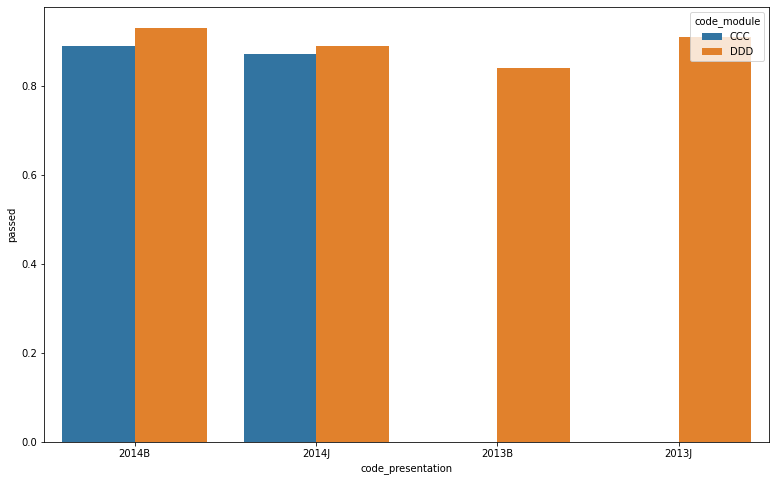

In [150]:
f, ax = plt.subplots(figsize=(13, 8))
g = sns.barplot(data = all_attempts, x='code_presentation',y='passed', hue='code_module')

**Самый сложный предмет 'DDD' 2013B семестра. Самый простой предмет - 'DDD' с семестром = 2014B.**

Выясним, какой семестр был самым сложным, а какой самым простым.

In [151]:
semesters =  who_passed.groupby('code_presentation', as_index = False)\
.agg({'id_student':'count'})\
.rename(columns={'id_student':'all_students'})

semesters

,code_presentation,all_students
0,2013B,602
1,2013J,968
2,2014B,1271
3,2014J,2118


In [152]:
sucsess_semestr = who_passed.query('score >=40').groupby('code_presentation', as_index = False)\
.agg({'id_student':'count'})\
.rename(columns={'id_student':'sucsess_students'})

sucsess_semestr

,code_presentation,sucsess_students
0,2013B,504
1,2013J,878
2,2014B,1149
3,2014J,1861


In [153]:
# завершаемость
semesters['sucsess_students'] = sucsess_semestr.sucsess_students
semesters['passed'] = round(sucsess_semestr.sucsess_students/semesters.all_students,2)
semesters

,code_presentation,all_students,sucsess_students,passed
0,2013B,602,504,0.84
1,2013J,968,878,0.91
2,2014B,1271,1149,0.90
3,2014J,2118,1861,0.88


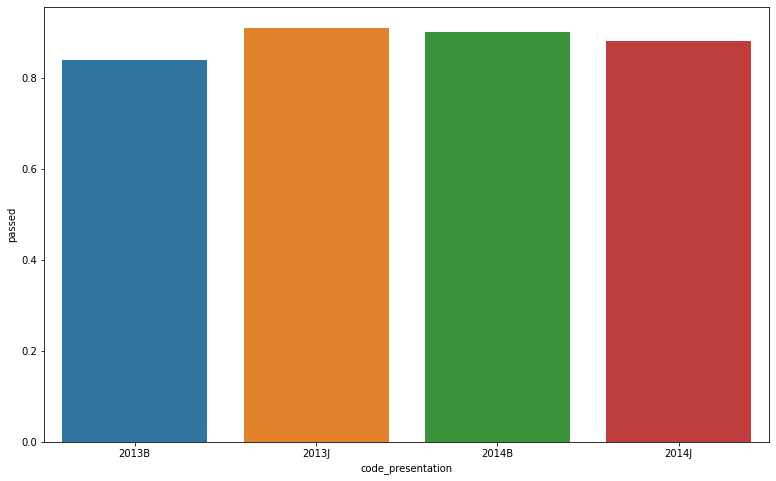

In [154]:
f, ax = plt.subplots(figsize=(13, 8))
g = sns.barplot(data = semesters, x='code_presentation',y='passed')

**Самыми сложными были экзамены в семестре 2013B, а самыми легкими в семестре 2013J.**

Какой предмет в целом оказался легче, а какой сложнее?

In [155]:
subject =  who_passed.groupby('code_module', as_index = False)\
.agg({'id_student':'count'})\
.rename(columns={'id_student':'all_students'})

subject

,code_module,all_students
0,CCC,1915
1,DDD,3044


In [156]:
sucsess_subject = who_passed.query('score >=40').groupby('code_module', as_index = False)\
.agg({'id_student':'count'})\
.rename(columns={'id_student':'sucsess_students'})
sucsess_subject

,code_module,sucsess_students
0,CCC,1683
1,DDD,2709


In [157]:
# завершаемость
subject['sucsess_students'] = sucsess_subject.sucsess_students
subject['passed'] = round(sucsess_subject.sucsess_students/subject.all_students,2)
subject

,code_module,all_students,sucsess_students,passed
0,CCC,1915,1683,0.88
1,DDD,3044,2709,0.89


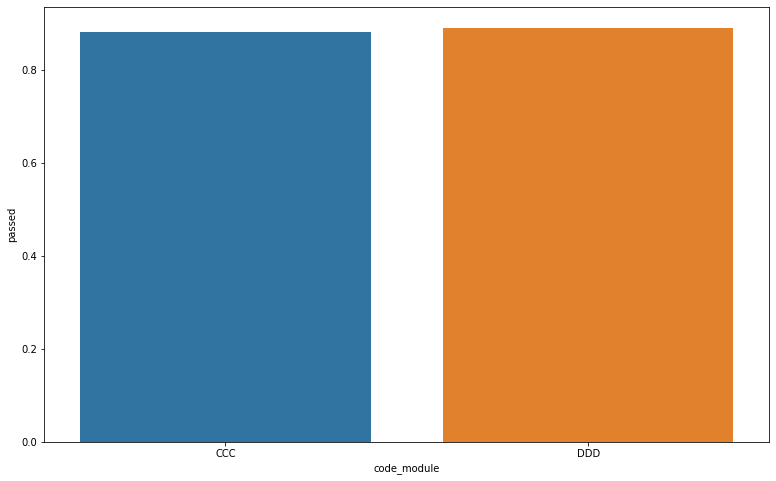

In [158]:
f, ax = plt.subplots(figsize=(13, 8))
g = sns.barplot(data = subject, x='code_module',y='passed')

**Экзамены по предмету 'DDD' имеют большую завершаемость, чем экзамены по предмету 'ССС'**

### Вывод: 
    
Завершаемость экзаменов вне зависимости от разреза семестр/предмет достаточно высокая (~0.8-0.9). 
Студентов, которые получили перезачет с прошлых семестров, нет, все сдавали экзамены как положено.
    
В разрезе предмет+семестр:
    
    Самый сложный предмет 'DDD' 2013B семестра. Самый простой предмет - 'DDD' с семестром = 2014B.
В разрезе семестра:
    
    Самые сложные экзамены в семестре 2013B, а самые легкие в семестре 2013J.
Предмет:
    
    Экзамены по предмету 'DDD' имеют большую завершаемость, чем экзамены по предмету 'ССС'. Это может быть связано с тем, что экзамен по предмету 'DDD' есть в 4-х семестрах, а значит большее количество людей сдает экзамен по этому предмету. 

## По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом).

В таблице assessments есть столбец 'date' с информацией об окончательной дате сдачи теста. А в таблице student_assessment столбец 'date_submitted' c датой сдачи теста студентом.
Предположим, что date - это дедлайн сдачи экзамена, а date_submitted - данные, когда студенты на самом деле сдавали. 

Возьмем таблицу с данными студетов, которые сдавали экзамен. Для некоторых экзаменов нет данных в date.

In [159]:
who_passed.query('date == "NaN"')

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
0,24290,558914,230,0,32.0,CCC,2014B,Exam,NaN,100.0
1,24290,559706,234,0,78.0,CCC,2014B,Exam,NaN,100.0
2,24290,559770,230,0,54.0,CCC,2014B,Exam,NaN,100.0
3,24290,560114,230,0,64.0,CCC,2014B,Exam,NaN,100.0
4,24290,560311,234,0,100.0,CCC,2014B,Exam,NaN,100.0
...,...,...,...,...,...,...,...,...,...,...
4954,25368,652680,243,0,91.0,DDD,2014J,Exam,NaN,100.0
4955,25368,652732,249,0,47.0,DDD,2014J,Exam,NaN,100.0
4956,25368,652965,242,0,87.0,DDD,2014J,Exam,NaN,100.0
4957,25368,653051,242,0,27.0,DDD,2014J,Exam,NaN,100.0


Отфильтруем пока что те, где нет данных по дедлайну и проверим превышает ли date_submitted дедлайн в date.

In [160]:
has_date = who_passed.query('date != "NaN"')

In [161]:
has_date['diff'] = has_date.date - has_date.date_submitted

Сколько студентов сдали экзамен после истечения дедлайна?

In [162]:
has_date.query('diff < 0')

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,diff
1923,25340,81351,248,0,0.0,DDD,2013B,Exam,240.0,100.0,-8.0
2217,25340,532491,241,0,49.0,DDD,2013B,Exam,240.0,100.0,-1.0
2244,25340,538611,241,0,51.0,DDD,2013B,Exam,240.0,100.0,-1.0
2305,25340,548535,241,0,60.0,DDD,2013B,Exam,240.0,100.0,-1.0
3547,25361,391924,251,0,69.0,DDD,2014B,Exam,241.0,100.0,-10.0
3898,25361,631388,242,0,78.0,DDD,2014B,Exam,241.0,100.0,-1.0
3930,25361,634383,242,0,96.0,DDD,2014B,Exam,241.0,100.0,-1.0


Студентов, сдавших экзамен после установленного срока сдачи, не так много. А самих тестов, по которым позже сдавались, всего два (id_assessment = 25340,25361). Возможно это связано, с днем/временем проведения экзамена или с индивидуальными причинами каждого студента.

Для нахождения среднего срока сдачи экзамена возьмем данные из date_submitted, т.к. с их помощью мы сможем увидеть, когда студенты на самом деле сдавали экзамены. Причем данные по студентам просрочившим дедлайн сдачи оставим, т.к. в основном опоздание было на 1 день, самые большие задержки - 8 и 10 дней. Но я не считаю их достаточно большими, чтоб понимать их как выбросы.

In [163]:
# всего 6 уникальных тестов с экзаменами
who_passed.id_assessment.nunique()

6

In [164]:
avr_date = who_passed.query('score >=40').groupby(['id_assessment','code_module','code_presentation'], as_index = False)\
          .agg({'date_submitted':'mean'}).round(2)\
          .rename(columns={'date_submitted':'avr_date'})
avr_date

,id_assessment,code_module,code_presentation,avr_date
0,24290,CCC,2014B,231.58
1,24299,CCC,2014J,244.40
2,25340,DDD,2013B,230.16
3,25354,DDD,2013J,239.51
4,25361,DDD,2014B,234.94
5,25368,DDD,2014J,242.80


In [165]:
avr_with_info = avr_date.merge(assessments, how = 'inner', on = 'id_assessment')[['id_assessment','code_module_x','code_presentation_x','avr_date','date']]
avr_with_info.rename(columns = {'code_module_x':'code_module', 'code_presentation_x':'code_presentation'})

,id_assessment,code_module,code_presentation,avr_date,date
0,24290,CCC,2014B,231.58,NaN
1,24299,CCC,2014J,244.40,NaN
2,25340,DDD,2013B,230.16,240.0
3,25354,DDD,2013J,239.51,261.0
4,25361,DDD,2014B,234.94,241.0
5,25368,DDD,2014J,242.80,NaN


Для некоторых тестов нет дедлайна: данные либо утеряны, либо эти тесты можно сдавать бессрочно. Но предположим, что данные утеряны, тогда дедлайн по сдаче экзамена можно приравнять к окончанию семестра. Длительность семестра указана в "module_presentation_length" таблице courses. 

Вычислим также средний срок здачи экзаменов для каждого семестра.

In [166]:
avr_date_semestr = who_passed.query('score >=40')\
                             .groupby('code_presentation', as_index = False)\
                             .agg({'date_submitted':'mean'}).round(2)\
                             .rename(columns={'id_student':'count_students','date_submitted':'avr_date'})
avr_date_semestr

,code_presentation,avr_date
0,2013B,230.16
1,2013J,239.51
2,2014B,233.00
3,2014J,243.68


И для каждого предмета в целом

In [167]:
avr_date_subject = who_passed.query('score >=40')\
                             .groupby(['code_module'], as_index = False)\
                             .agg({'date_submitted':'mean'}).round(2)\
                             .rename(columns={'date_submitted':'avr_date'})
avr_date_subject

,code_module,avr_date
0,CCC,239.35
1,DDD,237.98


## Вывод

Средний срок сдачи экзаменов не превышает установленный дедлайн ни в одном из вычисляемых условий(предмет/семестр/отдельный тест)

## Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3). (8 баллов)

Регистрация - отметка о регистрации в date_registration. Отток - факт регистрации, после которого была отмена регистрации на предмет.
Т.к. по условию нам важен только факт регистрации или отписки от предмета, то нам не важно сдал ли по нему студент экзамен/тест.

**Топ-3 по количеству регистраций**

Есть ли студенты, у которых нет данных в столбце date_registration?

In [168]:
no_registration = registration.query('date_registration == "Nan"')
no_registration

,code_module,code_presentation,id_student,date_registration,date_unregistration
2344,BBB,2013B,630346,NaN,NaN
2538,BBB,2013J,57369,NaN,-1.0
2759,BBB,2013J,342678,NaN,-33.0
5356,BBB,2014B,582496,NaN,-126.0
5490,BBB,2014B,607646,NaN,-38.0
5573,BBB,2014B,614270,NaN,-142.0
6295,BBB,2014B,2409808,NaN,-109.0
6305,BBB,2014B,2439442,NaN,-149.0
8307,BBB,2014J,694001,NaN,-36.0
8975,CCC,2014B,394791,NaN,-61.0


In [169]:
n=list(no_registration['id_student'])

Нужно подробней посмотреть на этих студентов, есть ли у них другие регистрации?

In [170]:
registration.query('id_student in @n')\
            .groupby('id_student', as_index = False)\
            .agg({'date_registration':'count'})\
            .query('date_registration != 0')

,id_student,date_registration
2,128965,1
6,394791,1
8,470119,1
9,535460,1
10,544271,1
11,550142,2
13,575419,1
15,591648,1
17,604398,1
22,607703,1


In [171]:
registration.query('id_student == 835603')

,code_module,code_presentation,id_student,date_registration,date_unregistration
10348,CCC,2014B,835603,-193.0,-82.0
16092,DDD,2013J,835603,NaN,-81.0
17402,DDD,2014B,835603,-137.0,-82.0


Из 43 студентов, у которых нет данных в date_registration, всего у 13 человек есть регистрация на других предметах/семестрах. Остальных сохраним в отдельном датафрейме, чтобы исключить из выборки, т.к. у большинства из них есть даты отмены регистрации, но нет дат самой регистрации, а это может повлиять на результаты вычисления оттока.

In [172]:
no_reg = registration.query('id_student in @n')\
                     .groupby('id_student', as_index = False)\
                     .agg({'date_registration':'count'})\
                     .query('date_registration == 0')

In [173]:
registration.query('id_student == 624767')

,code_module,code_presentation,id_student,date_registration,date_unregistration
31510,GGG,2014B,624767,-24.0,212.0
31994,GGG,2014J,624767,-24.0,NaN


Найдем топ-3 предмета по количеству регистраций. 

Т.к. у некоторых студентов несколько регистраций, то возьмем уникальное кол-во id_student, а не date_registration

In [174]:
reg_subject = registration.groupby('code_module', as_index = False)\
             ['id_student'].nunique()\
            .sort_values('id_student', ascending = False)
            
reg_subject.head(3)

,code_module,id_student
1,BBB,7692
5,FFF,7397
3,DDD,5848


Посмотрим также топ-3 предмета в разрезе каждого семестра

In [175]:
reg_sub_by_sem = registration.groupby(['code_module','code_presentation'], as_index = False)\
             ['id_student'].nunique()\
            .sort_values('id_student', ascending = False)
            
reg_sub_by_sem.head(3)

,code_module,code_presentation,id_student
7,CCC,2014J,2498
18,FFF,2014J,2365
5,BBB,2014J,2292


**Топ-3 с самым большим оттоком**

In [176]:
# не забываем исключить студентов с отсутствующими данными
n = no_reg.id_student.tolist()

In [177]:
# уникальное количество студентов, которые отменяли регистрацию
unreg = registration.query('id_student not in @n and date_unregistration != "NaN"')\
                    .groupby('code_module', as_index = False)\
                    ['id_student'].nunique()\
                    .rename(columns = {'id_student':'count_student'})
unreg.head(3)

,code_module,count_student
0,AAA,116
1,BBB,2306
2,CCC,1856


In [178]:
# добавим в таблицу общее количество зарегестрировавшихся студентов
unreg['all_student'] = reg_subject['id_student']
unreg

,code_module,count_student,all_student
0,AAA,116,712
1,BBB,2306,7692
2,CCC,1856,4251
3,DDD,2059,5848
4,EEE,692,2859
5,FFF,2240,7397
6,GGG,287,2525


In [179]:
# посчитаем отток
unreg['outflow'] = round(unreg.count_student/unreg.all_student,3)
unreg.sort_values('outflow',ascending = False).head(3)

,code_module,count_student,all_student,outflow
2,CCC,1856,4251,0.437
3,DDD,2059,5848,0.352
5,FFF,2240,7397,0.303


Теперь вычислим отток по предметам за каждый семестр

In [180]:
unreg_by_sem = registration.query('id_student not in @n and date_unregistration != "NaN"')\
                           .groupby(['code_module','code_presentation'], as_index = False)\
                            ['id_student'].nunique()\
                           .rename(columns = {'id_student':'count_student'})
        
unreg_by_sem.head(5)

,code_module,code_presentation,count_student
0,AAA,2013J,60
1,AAA,2014J,66
2,BBB,2013B,505
3,BBB,2013J,645
4,BBB,2014B,484


In [181]:
# добавим в таблицу общее количество зарегестрировавшихся студентов
unreg_by_sem['all_student'] = reg_sub_by_sem['id_student']
unreg_by_sem.head(5)

,code_module,code_presentation,count_student,all_student
0,AAA,2013J,60,383
1,AAA,2014J,66,365
2,BBB,2013B,505,1767
3,BBB,2013J,645,2237
4,BBB,2014B,484,1613


In [182]:
# посчитаем отток
unreg_by_sem['outflow'] = round(unreg_by_sem.count_student/unreg_by_sem.all_student,3)
unreg_by_sem.sort_values('outflow',ascending = False).head(3)

,code_module,code_presentation,count_student,all_student,outflow
6,CCC,2014B,896,1936,0.463
7,CCC,2014J,1049,2498,0.420
10,DDD,2014B,488,1228,0.397


### Вывод:

Топ-3 предмета по количеству регистраций:
    
    BBB - 7692
    FFF - 7397
    DDD - 5848
    
Топ-3 премета в зависимости от семестра:
    
    CCC - 2014J - 2498
    FFF - 2014J - 2365
    BBB - 2014J - 2292
    
Топ-3 предмета с самым большим оттоком:
    
    CCC	- 43.7%
    DDD	- 35.2%
    FFF	- 30.3%
    
Топ-3 предмета с самым большим оттоком в зависимости от семестра: 

    CCC	 2014B - 46.3%
    CCC	 2014J - 42.0%
    DDD	 2014B - 39.7%
    
Процент оттока достаточно большой ~30-40%. Если рассматривать отток по семестрам, то он выше, чем в целом по предметам.

## Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.

В период 2013-2014 у нас есть 4 семестра: 2013B, 2013J, 2014J, 2014B. Так как у нас нет никаких конкретных дат/времени, то определить точно какой семестр первый, какой второй нельзя. Поэтому установим, что они идут в алфавитном порядке:
    
    2013B
    2013J 
    2014B
    2014J 

Берем таблицу, в которой у нас все студенты, сдававшие экзамены. Проверим, что у всех есть date_submitted.

In [183]:
who_passed.query('date_submitted == "NaN"')

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight


У всех есть значения date_submitted.

Средний срок успешной сдачи экзамена

In [184]:
# таблица из задания 3
avr_date 

,id_assessment,code_module,code_presentation,avr_date
0,24290,CCC,2014B,231.58
1,24299,CCC,2014J,244.40
2,25340,DDD,2013B,230.16
3,25354,DDD,2013J,239.51
4,25361,DDD,2014B,234.94
5,25368,DDD,2014J,242.80


Оценим завершаемость курсов

In [185]:
# табл. из задания 2
all_attempts

,code_module,code_presentation,all_students,sucsess_students,passed
0,CCC,2014B,747,664,0.89
1,CCC,2014J,1168,1019,0.87
2,DDD,2013B,602,504,0.84
3,DDD,2013J,968,878,0.91
4,DDD,2014B,524,485,0.93
5,DDD,2014J,950,842,0.89


Для каждой таблицы построим сводную и тепловую диаграмму

In [186]:
cohort_date = avr_date.pivot_table(index = 'code_module', columns = 'code_presentation', values = 'avr_date')

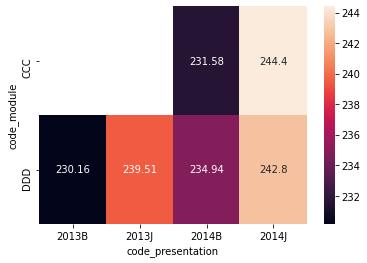

In [187]:
sns.heatmap(cohort_date, annot = True, fmt = '')

In [188]:
cohort_pass = all_attempts.pivot_table(index = 'code_module', columns = 'code_presentation', values = 'passed')

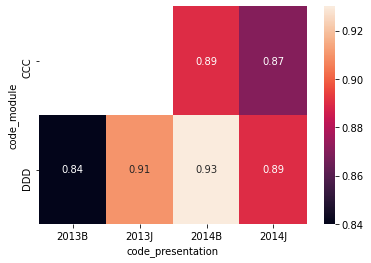

In [189]:
sns.heatmap(cohort_pass, annot = True, fmt = '')

## Вывод:

Семестр с самой низкой завершаемостью - 2013B, c рейтингом 0.84

Семестр с самыми долгими средними сроками сдачи - 2014J, со сроком 244.4 

Но вообще в нашем случае когортный анализ не слишком хорошо подходит:

- данных немного;
- студенты не проходят предметы из семестра в семестр;
- не во всех семестрах 2 курса;
- не все студенты сдавали оба предмета.

###  Используя python, построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. 

В адаптированной кластеризации будем использовать следующие метрики: 
   
   R - период сдачи одного экзамена, 
   F - завершаемость курсов, 
   M - среднее количество баллов, получаемое за экзамен.

**R - период сдачи одного экзамена**

Лучше всего разделить студентов на несколько категорий, т.к. длина семестров разная и экзамен мог быть назначен в разные дни. Категории будут меняться в зависимотсти от периода сдачи экзамена.

Выберем 3 категории студентов:

- Студент пытался сдать, но не сдал экзамен
- Сдал после окончания семестра
- Сдал до конца семестра

Если студент не сдал экзамен, то он не мог получитьи оценку выше 40, а также завергить курс.

**F - завершаемость курсов**

Никто из студентов не завершал более 2х курсов.

3 категории студентов:

- Студент не завершил курс
- Завершил один курс
- Завершил два курса

**M - среднее количество баллов, получаемое на экзамене**

Здесь у нас будет 4 категории :

Успешно сдачей считается, если кол-во баллов не ниже 40. Те, кто получил оценку ниже - с экзаменом не справились.

4 категории студентов:

- Получил меньше 40 баллов
- Получил от 40 до 65 баллов - Удовлетворительно
- Получил от 65 до 85 баллов - Хорошо
- Получил 85 и больше - Отлично

Возьмем таблицу с данными студентов, сдававшими экзамены

In [190]:
who_passed.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
0,24290,558914,230,0,32.0,CCC,2014B,Exam,NaN,100.0
1,24290,559706,234,0,78.0,CCC,2014B,Exam,NaN,100.0
2,24290,559770,230,0,54.0,CCC,2014B,Exam,NaN,100.0
3,24290,560114,230,0,64.0,CCC,2014B,Exam,NaN,100.0
4,24290,560311,234,0,100.0,CCC,2014B,Exam,NaN,100.0


Узнаем, сколько всего студентов сдавали экзамены

In [191]:
total_students  = who_passed \
        .groupby(['id_student'], as_index=False) \
        .id_student.nunique() \
        .sum()
total_students

id_student    4633
dtype: int64

Добавим к нашей таблице информацию о длине семестра

In [192]:
exam_info = who_passed.merge(courses, how = 'inner', on = ['code_module', 'code_presentation'])
exam_info.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,module_presentation_length
0,24290,558914,230,0,32.0,CCC,2014B,Exam,NaN,100.0,241
1,24290,559706,234,0,78.0,CCC,2014B,Exam,NaN,100.0,241
2,24290,559770,230,0,54.0,CCC,2014B,Exam,NaN,100.0,241
3,24290,560114,230,0,64.0,CCC,2014B,Exam,NaN,100.0,241
4,24290,560311,234,0,100.0,CCC,2014B,Exam,NaN,100.0,241


Посчитаем в отдельной колонке разницу между длиной семестра и сдачей экзамена


In [193]:
exam_info['diff_for_R'] =  exam_info['date_submitted'] - exam_info['module_presentation_length']

Распределим по R категориям студентов 

In [194]:
# Проставим значение recency = 1  студентам, несдавшим экзамен
rec_1 = exam_info.query('score < 40') \
        .groupby('id_student', as_index=False)\
        .diff_for_R.mean() \
        .rename(columns={'diff_for_R': 'recency'})
rec_1['recency'] = 1

# Проставим значение recency = 2  студентам, сдавшим после окончания семестра
rec_2 = exam_info.query('score >= 40 & diff_for_R > 0')\
        .groupby('id_student', as_index=False)\
        .diff_for_R.mean() \
        .rename(columns={"diff_for_R": "recency"})
rec_2['recency'] = 2

# Проставим значение recency = 3  студентам, сдавшим до окончания семестра
rec_3 = exam_info.query('score >= 40 & diff_for_R < 0')\
        .groupby('id_student', as_index=False)\
        .diff_for_R.mean() \
        .rename(columns={"diff_for_R": "recency"})
rec_3['recency'] = 3
# Объеденим все в 1 датафрейм, удалив дубликаты
recency = pd.concat([rec_3, rec_2, rec_1]).drop_duplicates('id_student')

In [195]:
recency.head()

,id_student,recency
0,23698,3
1,24213,3
2,27116,3
3,28046,3
4,28787,3


Сравним кол-во студентов с общим кол-вом сдававших

In [196]:
recency.shape

(4633, 2)

Количество сходится

Распределим по F категориям студентов 

In [197]:
#frequency = количество завершенных курсов + 1 - студентам, успешно сдавшим экзамен
frequency_s = exam_info \
    .query('score >= 40 & is_banked == 0') \
    .groupby(['id_student'], as_index=False) \
    .code_module.count() \
    .rename(columns={'code_module': 'frequency'}) \
    .sort_values('frequency')
frequency_s.frequency += 1

# frequency = 1 cтудентам, несдавшим экзамен
frequency_f = exam_info \
    .query('score < 40 & is_banked == 0') \
    .groupby(['id_student'], as_index=False) \
    .code_module.count() \
    .rename(columns={'code_module': 'frequency'}) \
    .sort_values('frequency')
frequency_f.frequency = 1

# Объеденим все в 1 датафрейм, удалив дубликаты
frequency = pd.concat([frequency_s, frequency_f]).drop_duplicates('id_student')

In [198]:
frequency.head()

,id_student,frequency
0,23698,2
2694,627399,2
2695,627401,2
2696,627417,2
2697,627453,2


Сравним количество студентов

In [199]:
frequency.shape

(4633, 2)

Количество сходится

Распределим по M категориям студентов 

In [200]:
monetary = exam_info \
    .groupby(['id_student'], as_index=False) \
    .agg({'score': 'mean'}) \
    .rename(columns={'score': 'monetary'})

q = [0,40,65,85,101]
monetary.monetary = pd.cut(monetary.monetary, q, right=False, labels=[1, 2, 3, 4])

In [201]:
monetary.head()

,id_student,monetary
0,23698,3
1,24213,2
2,27116,4
3,28046,2
4,28787,2


Сравним количество студентов

In [202]:
monetary.shape

(4633, 2)

Количество сходится

**Объеденим полученные данные в один датафрейм RFM**

In [203]:
RFM = pd.merge(recency,frequency, on="id_student").merge(monetary, on="id_student")

In [204]:
RFM.head()

,id_student,recency,frequency,monetary
0,23698,3,2,3
1,24213,3,2,2
2,27116,3,2,4
3,28046,3,2,2
4,28787,3,2,2


Теперь нужно объединить категории в одном столбце. Для этого поменяем формат на str и объединим.

In [205]:
RFM.recency = RFM.recency.astype(str)
RFM.frequency = RFM.frequency.astype(str)
RFM.monetary = RFM.monetary.astype(str)

In [206]:
RFM.monetary

0       3
1       2
2       4
3       2
4       2
       ..
4628    1
4629    1
4630    1
4631    1
4632    1
Name: monetary, Length: 4633, dtype: object

In [207]:
RFM['rfm'] = RFM.recency + RFM.frequency + RFM.monetary

In [208]:
RFM.rfm.value_counts()

322    1658
323    1310
324     817
111     536
333     115
334      93
332      87
321       7
222       6
223       3
224       1
Name: rfm, dtype: int64

Визуализируем полученные данные

In [209]:
rfm_f = RFM.groupby('rfm',as_index=False)\
           .id_student.nunique()\
           .rename(columns={'id_student':'value'})\
           .sort_values('value', ascending=False)

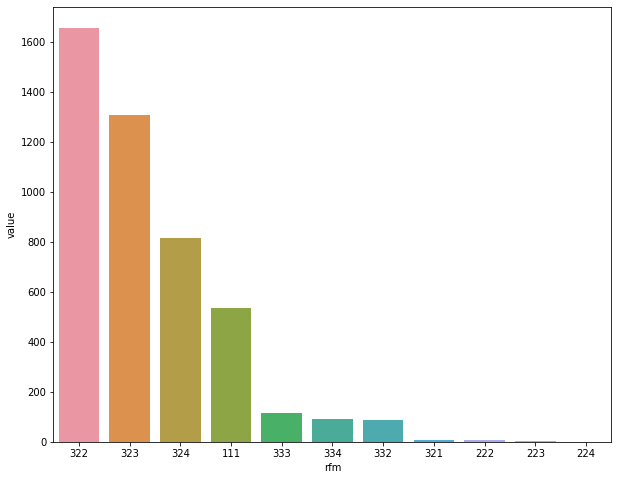

In [210]:
f, ax1 = plt.subplots(1, figsize=(10, 8), sharex=True)
sns.barplot(data = rfm_f,x='rfm', y='value')

## Вывод:
    
По итогу проведения анализа, мы получили 11 кластеров:
    
- 322 - студенты, завершившие только один курс в срок с оценкой "Удовлетворительно"
- 323 - студенты, завершившие только один курс в срок с оценкой "Хорошо"
- 324 - студенты, завершившие только один курс в срок с оценкой "Отлично"
- 111 - студенты, которые не завершили ни одного курса
- 333 - студенты, завершившие два курса в срок с оценкой "Хорошо"
- 334 - студенты, завершившие два курса в срок с оценкой "Отлично"
- 332 - студенты, завершившие два курса в срок с оценкой "Удовлетворительно"
- 321 - студенты, сдавшие экзамен по одному курсу, но получившие оценку "Неудовлетворительно"
- 222 - студенты, которые сдали экзамен после окончания семестра, завершили один курс с оценкой "Удовлетворительно"
- 223 - студенты, которые сдали экзамен после окончания семестра, завершили один курс с оценкой "Хорошо"
- 224 - студенты, которые сдали экзамен после окончания семестра, завершили один курс с оценкой "Отлично"


Мы видим, что больше всего студентов, которые сдали всего один курс, причем получив по нему только проходную оценку. Большее количество студентов проходят только один курс или вообще не завершают ни одного. Стоит обратить внимание на это и разобраться, почему ученики не хотят проходить новые курсы. Также необходимо обратить внимание, что большинство студентов получили оценку "Удовлетворительно". Возможно причины этих проблем в информативности курсов, подаче материала или несоотвествии теоретической части практическим заданиям. Также возможно отсутствие хорошей рекламы и бонусной системы влияет на количество изучаемых курсов. 